In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from testing_framework.tests import test_contextual_algorithm
from arms.bernoulli import ContextualBernoulliArm
from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


In [2]:
class Net(nn.Module):
    def __init__(self, s_size = 3, a_size = 4):
        super(Net, self).__init__()
        self.fc = torch.nn.Linear(s_size, a_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

class DeepBanditPytorch():
    
    def __init__(self,n_contexts):
        self.e = 0.1
        self.n_contexts = n_contexts
    
    def initialize(self, n_arms):
        self.n_arms = n_arms
        self.net = Net()
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.01, betas=(0.9, 0.999))
    
    def select_arm(self,context):
        context_one_hot = to_categorical(context, num_classes=self.n_contexts)
        context_tensor = torch.tensor(context_one_hot)
        outputs = self.net(context_tensor)
    
        if np.random.rand(1) < self.e:
            action = np.random.randint(self.n_arms)
        else:
            action = torch.argmax(outputs)
        self.responsible_weight = outputs[action]
        return action

    def update(self, chosen_arm, reward):
        if reward == 0:
            reward = -1
        loss = -(torch.log(self.responsible_weight)*reward)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [3]:
random.seed(1)
means_for_context = [[0.1,0.2,0.9],[0.8,0.2,0.3],[0.2,0.2,0.4],[0.1,0.9,0.1]]
arms = list(map(lambda mu: ContextualBernoulliArm(mu), means_for_context))
n_arms = len(arms)
n_contexts = len(means_for_context[0])
for context in range(n_contexts):
    print('best arm for context ' + str(context) + ' is ' + str(np.argmax(list(zip(*means_for_context))[context])))

best arm for context 0 is 1
best arm for context 1 is 3
best arm for context 2 is 0


In [4]:
%%time
algo = DeepBanditPytorch(n_contexts)
algo.initialize(n_arms)
results = test_contextual_algorithm(algo, arms, n_contexts, 5000, 1000)
dataframe = pd.DataFrame(np.array(results).T,columns=["Sim", "T", "Context", "ChosenArm", "Reward", "CumulativeReward"])

CPU times: user 2h 23min 55s, sys: 1min 37s, total: 2h 25min 33s
Wall time: 36min 47s


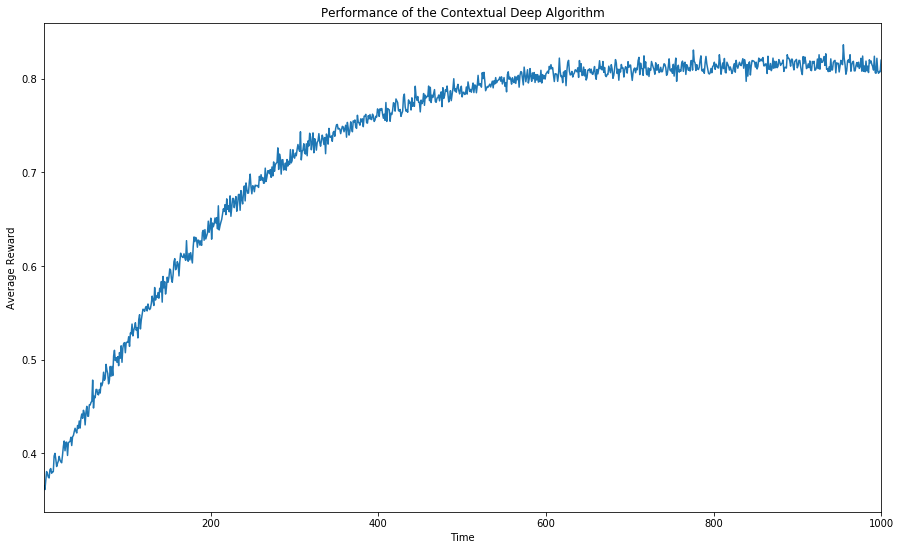

In [5]:
ax = dataframe.groupby("T").mean()['Reward'].plot(figsize=(15,9))
ax.set_title("Performance of the Contextual Deep Algorithm")
ax.set_ylabel('Average Reward');
ax.set_xlabel('Time');

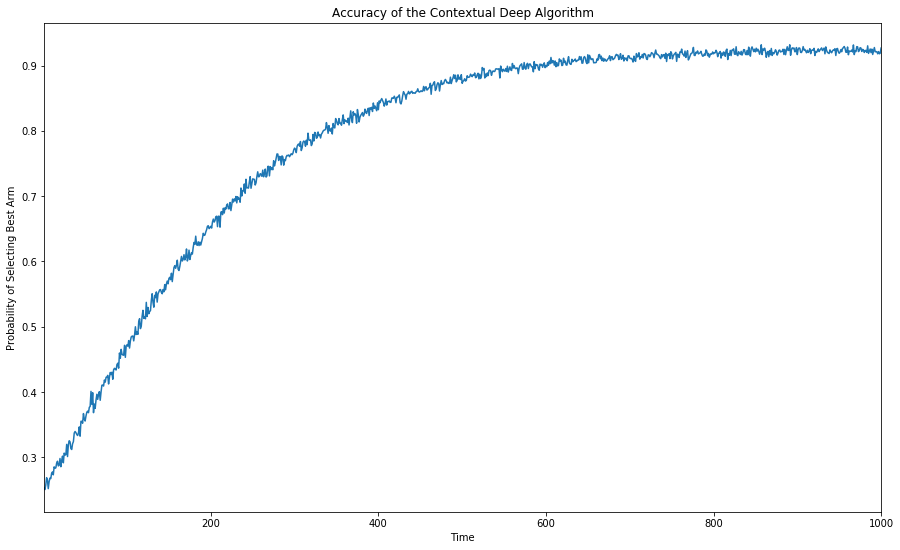

In [6]:
dataframe['BestArm'] = 0
for context in range(n_contexts):
    dataframe.loc[(dataframe.Context == float(context)) & (dataframe.ChosenArm == float(np.argmax(list(zip(*means_for_context))[context]))),'BestArm'] = 1
df_grouped = dataframe.groupby(["T","BestArm"]).count()/dataframe.Sim.max()
df_grouped = df_grouped.reset_index()
ax = df_grouped[df_grouped['BestArm'] == 1].set_index('T')['Reward'].plot(figsize=(15,9))
ax.set_title("Accuracy of the Contextual Deep Algorithm")
ax.set_ylabel('Probability of Selecting Best Arm');
ax.set_xlabel('Time');

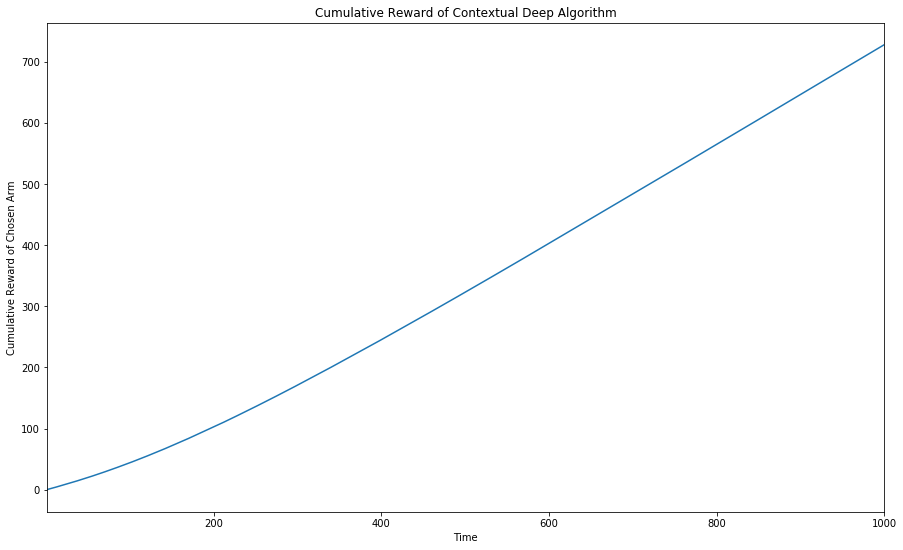

In [7]:
ax = dataframe.groupby("T").mean()['CumulativeReward'].plot(figsize=(15,9))
ax.set_title("Cumulative Reward of Contextual Deep Algorithm")
ax.set_ylabel('Cumulative Reward of Chosen Arm');
ax.set_xlabel('Time');